<a href="https://colab.research.google.com/github/learnstructure/phd/blob/main/V5_pushover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [69]:
!pip install openseespy

In [70]:
!pip install opsvis

In [71]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import math

#OOP model

In [72]:
class ConcreteMander:
  def __init__(self, fc_prime, D, cover, dh, sh, fyh, esm):
    Asp = math.pi * dh**2/4
    self.fc_prime = fc_prime
    self.ds = D-2*cover-dh
    self.fl_prime = 2 * Asp * fyh / (self.ds * sh)
    self.fyh = fyh
    self.esm = esm
    self.rho = 4 * Asp / (self.ds * sh)
    self.Ec = 57 * math.sqrt(fc_prime*1000)

  def fcc_prime(self):
    k1 = 2.254*math.sqrt(1+7.94*self.fl_prime/self.fc_prime)
    return self.fc_prime * (-1.254+k1-2*self.fl_prime/self.fc_prime)

  def ecc(self):
    return 0.002 * (1+5*(self.fcc_prime()/self.fc_prime-1))

  def ecu(self):
    return 0.004 + 1.4 * self.rho * self.fyh * self.esm / self.fcc_prime()

  def fc(self, e, fcc_prime, ecc):
    x = e/ecc
    Esec = fcc_prime/ecc
    r = self.Ec / (self.Ec - Esec)
    fc = fcc_prime * x * r / (r-1+x**r)
    return fc

  def confined_props(self):
    fcc_prime = self.fcc_prime()
    ecc = self.ecc()
    ecu = self.ecu()
    fc = self.fc(ecu, fcc_prime, ecc)
    return [fcc_prime, ecc, fc, ecu]

  def unconfined_props(self):
    fc = self.fc(0.005, self.fc_prime, 0.002)
    return [self.fc_prime, 0.002, 0, 0.005]     #0 to be replaced by fc


class RCCColumnPushover:
    def __init__(self, fc_prime, D, H, cover,
                 nBars, db,
                 fy, fu, Es, Esh, eps_sh, eps_ult,
                 dh, sh, fyh, esm,
                 P_axial=0.0,
                 nAng=64, nRad=32, nRad_cover=8, beamIntegration = "HingeRadau",
                 confined_props=None, unconfined_props=None, concrete_model = "Concrete01",
                 Lp = None, k_factor = None):
        """
        Initialize column geometry and material parameters.
        """
        self.fc_prime = fc_prime
        self.D = D
        self.H = H
        self.cover = cover
        self.nBars = nBars
        self.db = db
        self.fy, self.fu, self.Es, self.Esh = fy, fu, Es, Esh
        self.eps_sh, self.eps_ult = eps_sh, eps_ult

        self.A = math.pi * D**2 / 4
        self.Ast = nBars * math.pi * db**2 / 4

        self.dh = dh
        self.sh = sh
        self.fyh = fyh
        self.esm = esm

        self.R_core = D / 2 - cover - self.dh / 2
        self.r_bar = D / 2 - cover - self.dh - db / 2.0

        self.confined_props, self.unconfined_props = confined_props, unconfined_props
        if confined_props is None:
            self.confined_props = [-x for x in ConcreteMander(fc_prime, D, cover, dh, sh, fyh, esm).confined_props()]
        if unconfined_props is None:
            self.unconfined_props = [-x for x in ConcreteMander(fc_prime, D, cover, dh, sh, fyh, esm).unconfined_props()]

        self.P_axial = P_axial
        self.nAng, self.nRad, self.nRad_cover = nAng, nRad, nRad_cover     #no of division in angular and radial direction
        self.secTag = 1
        self.built = False
        self.e_sy = fy/Es
        self.fib_sec = None
        self.beamIntegration = beamIntegration
        self.Lp = Lp
        self.Ec = 57 * math.sqrt(fc_prime*1000)
        self.k_factor = self.stiffness_factor() if k_factor is None else k_factor
        self.concrete_model = concrete_model

    # -------------------------
    # Model Setup
    # -------------------------
    def build_model(self):
        ops.wipe()
        ops.model('basic', '-ndm', 2, '-ndf', 3)

        # Geometry
        D, H, cover, db = self.D, self.H, self.cover, self.db
        R_outer = D / 2.0
        R_core, r_bar = self.R_core, self.r_bar
        Ab = math.pi * (db / 2.0) ** 2

        # Nodes and BCs
        ops.node(1, 0.0, 0.0)
        ops.node(2, 0.0, H)
        ops.fix(1, 1, 1, 1)

        # Materials
        if self.concrete_model == "Concrete01":
          ops.uniaxialMaterial('Concrete01', 1, *self.confined_props)
          ops.uniaxialMaterial('Concrete01', 2, *self.unconfined_props)
        elif self.concrete_model == "Concrete04":
          conf = self.confined_props
          unconf = self.unconfined_props
          ops.uniaxialMaterial('Concrete04', 1, conf[0], conf[1], conf[3], self.Ec)
          ops.uniaxialMaterial('Concrete04', 2, unconf[0], unconf[1], unconf[3], self.Ec)
        else:
          raise ValueError(f"Invalid concrete model: {self.concrete_model}")

        ops.uniaxialMaterial('ReinforcingSteel', 3,
                             self.fy, self.fu, self.Es, self.Esh,
                             self.eps_sh, self.eps_ult)

        print("unconfined props:", self.unconfined_props)
        print("confined props:", self.confined_props)
        print("Reinforcing steel props:", self.fy, self.fu, self.Es, self.Esh,
                             self.eps_sh, self.eps_ult)

        # Fiber section definition
        I = math.pi * (R_outer ** 4) / 4
        G = self.Ec/(2*(1+0.2))
        J = 2 * I
        print("G, J, GJ=", G, J, G*J)
        self.fib_sec = [
            ['section', 'Fiber', self.secTag, '-GJ', G*J],
            ['patch', 'circ', 1, self.nAng, self.nRad, 0.0, 0.0, 0.0, R_core, 0.0, 360.0],
            ['patch', 'circ', 2, self.nAng, self.nRad_cover, 0.0, 0.0, R_core, R_outer, 0.0, 360.0],
            ['layer', 'circ', 3, self.nBars, Ab, 0.0, 0.0, r_bar, 0.0, 360.0]
        ]
        opsv.fib_sec_list_to_cmds(self.fib_sec)

        #section('Elastic', secTag, E_mod, A, Iz, G_mod=None, alphaY=None)
        ops.section('Elastic', 2, self.Ec, self.A, I * self.k_factor)
        print("I-modifier=", self.k_factor)

        if self.Lp is None:
            self.Lp = 0.08*H+0.15*db * self.fy
            if self.Lp<0.3*db*self.fy:
              self.Lp = 0.3*db*self.fy
            print(f"Plastic hinge length: {self.Lp:.2f} in")

        # Transformation and element
        ops.geomTransf('PDelta', 1)
        ops.beamIntegration('HingeRadau', 1, self.secTag, self.Lp, self.secTag, 0, 2)
        ops.beamIntegration('Lobatto', 2, self.secTag, 5)
        ops.beamIntegration('HingeEndpoint', 3, self.secTag, self.Lp, self.secTag, 0, 2)
        ops.beamIntegration('ConcentratedCurvature', 4, self.secTag, self.Lp, self.secTag, 0, 2)

        match self.beamIntegration:
            case "Lobatto":
                integrationTag = 2
            case "HingeEndpoint":
                integrationTag = 3
            case "ConcentratedCurvature":
                integrationTag = 4
            case _:
                integrationTag =1

        #element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)
        ops.element('forceBeamColumn', 1, 1, 2, 1, integrationTag)

        self.built = True

    # -------------------------
    # Gravity Load
    # -------------------------
    def run_gravity_load(self):
        P_axial = self.P_axial + 0.0000868 * math.pi * self.D **2 /4 * self.H
        print("Total axial load =", P_axial)
        if not self.built:
            self.build_model()
        ops.timeSeries('Linear', 1)
        ops.pattern('Plain', 1, 1)
        ops.load(2, 0.0, -P_axial, 0.0)

        ops.system('BandGeneral')
        ops.constraints('Transformation')
        ops.numberer('RCM')
        ops.test('NormDispIncr', 1.0e-7, 100)
        ops.algorithm('Newton', '-initial')
        ops.integrator('LoadControl', 0.1)
        ops.analysis('Static')
        ops.analyze(10)
        ops.loadConst('-time', 0.0)
        print("✅ Gravity load applied.")

    # -------------------------
    # Pushover Analysis
    # -------------------------
    def run_pushover(self, max_disp=30.0, dU=0.05, dropLimit=0.85):
        if not self.built:
            raise RuntimeError("Model not built. Run build_model() first.")

        for f in ['disp.out', 'baseReac.out']:
            if os.path.exists(f):
                os.remove(f)

        ops.timeSeries('Linear', 2)
        ops.pattern('Plain', 2, 2)
        ops.load(2, 1.0, 0.0, 0.0)

        ops.recorder('Node', '-file', 'disp.out', '-node', 2, '-dof', 1, 'disp')
        ops.recorder('Node', '-file', 'baseReac.out', '-node', 1, '-dof', 1, 'reaction')
        R_core, r_bar = self.R_core, self.r_bar

        ops.recorder('Element','-ele',1,'-file','steelModel.out','section',1,'fiber',r_bar,0,3,'stressStrain')
        ops.recorder('Element','-ele',1,'-file','concreteModel.out','section',1,'fiber',-R_core,0,1,'stressStrain')

        ops.test('NormDispIncr', 1.0e-7, 1000)
        ops.algorithm('ModifiedNewton', '-initial')
        ops.system('BandGeneral')
        ops.numberer('RCM')
        ops.integrator('DisplacementControl', 2, 1, dU, 1, dU, dU)
        ops.analysis('Static')

        peakShear = 0.0
        ok = 0
        step = 0
        currentDisp = 0.0
        yield_disp = None
        epsU_conc = self.confined_props[-1]    # ultimate compressive strain for confined concrete
        epsU_steel = self.eps_ult      # ultimate tensile strain for steel
        peakShear = 0.0
        print("🚀 Starting pushover...")

        while currentDisp < max_disp:
            ok = ops.analyze(1)
            if ok != 0:
                print(f"❌ Analysis failed to converge at step {step}, disp = {currentDisp:.3f} in")
                break

            step += 1
            currentDisp = ops.nodeDisp(2, 1)
            ops.reactions()
            baseShear = -ops.nodeReaction(1, 1)

            if baseShear > peakShear:
                peakShear = baseShear
            if baseShear < dropLimit * peakShear:
                print(f"⚠️ Strength dropped below 85% at disp = {currentDisp:.3f} in")
                break

            eps_tens = ops.eleResponse(1, 'section',1,'fiber',r_bar,0,3,'stressStrain')[1]
            eps_comp = ops.eleResponse(1, 'section',1,'fiber',-R_core,0,1,'stressStrain')[1]

            if eps_tens > self.e_sy and yield_disp is None:
                yield_disp = currentDisp
                yield_step = step
                print(f"⚠️ Yield reached at disp = {currentDisp:.3f} in at step = {yield_step}")

            if eps_tens > epsU_steel:
                print(f"⚠️ Steel fiber reached εu = {eps_tens:.4f} (> {epsU_steel}) "
                      f"at disp = {currentDisp:.3f} in")
                break

            if eps_comp < epsU_conc:
                print(f"⚠️ Concrete fiber reached εu = {eps_comp:.4f} (< {epsU_conc}) "
                      f"at disp = {currentDisp:.3f} in")
                break

            if step % 20 == 0:
                print(f"Step {step}: Disp = {currentDisp:.3f} in, Vb = {baseShear:.2f} kip")

        print("✅ Pushover complete.")
        return yield_step

    # -------------------------
    # Results Extraction
    # -------------------------
    def get_results(self):
        disp = pd.read_csv('disp.out', sep=r'\s+', header=None, names=['Disp'])
        reac = pd.read_csv('baseReac.out', sep=r'\s+', header=None, names=['Reac'])
        pushover = pd.DataFrame({
            'Disp (in)': disp['Disp'],
            'Base Shear (kip)': -reac['Reac']
        })
        zero = pd.DataFrame({'Disp (in)': [0.0], 'Base Shear (kip)': [0.0]})
        pushover = pd.concat([zero, pushover], ignore_index=True)
        pushover.to_csv('pushover_results.csv', index=False)
        print("📊 Results saved to pushover_results.csv")
        return pushover

    def plot_fib_section(self, fillflag=1, matcolor=['gold', 'lightgrey', 'red']):
        opsv.plot_fiber_section(self.fib_sec, fillflag, matcolor)

    def plot_steel_model(self):
        steel_df = pd.read_csv('steelModel.out', sep=r'\s+', header=None, names=['stress', 'strain'])
        steel_df.plot(x='strain', y='stress', title='Steel Stress-Strain Curve')
        return steel_df

    def plot_concrete_model(self):
        concrete_df = pd.read_csv('concreteModel.out', sep=r'\s+', header=None, names=['stress', 'strain'])
        concrete_df.plot(x='strain', y='stress', title='Concrete Stress-Strain Curve')
        return concrete_df

    def get_outermost_core_mesh_area(self):
        R_core = self.R_core
        dr = R_core / self.nRad
        outermost_core_mesh_area = math.pi * (R_core**2-(R_core-dr)**2) / self.nAng
        core_area = math.pi * R_core**2
        return outermost_core_mesh_area * 100 / core_area

    def stiffness_factor(self):
        pl = self.Ast/self.A         # Reinforcement ratio
        pdl = self.P_axial/(self.fc_prime*self.A)

        aei = 25.213*pl-2.1765
        bei = -19.503*pl+1.4883
        cei = 16.384*pl+0.0857

        eff = (aei*pdl*pdl+bei*pdl+cei)
        return eff

def caltrans_bilinear(pushover_df, yield_index):
    """
    Generate Caltrans-style bilinear pushover idealization.
    - First branch: elastic slope up to yield, extended linearly until Δp
    - Second branch: horizontal (constant strength)
    - Area equality enforced beyond yield point.
    """

    x = pushover_df['Disp (in)'].to_numpy()
    y = pushover_df['Base Shear (kip)'].to_numpy()

    # Extract key points
    Dy, Vy = x[yield_index], y[yield_index]
    Du, Vu = x[-1], np.max(y)
    Ke = Vy / Dy  # elastic slope

    # Actual area beyond yield
    area_actual = np.trapezoid(y[yield_index:], x[yield_index:])

    # Function to compute area under bilinear idealized curve (beyond yield)
    def bilinear_area(Dp):
        # beyond yield: from Dy → Dp (still increasing linearly), then horizontal at Vp
        Vp = Vy + Ke * (Dp - Dy)
        area1 = 0.5 * (Vp + Vy) * (Dp - Dy)  # trapezoid under rising branch
        area2 = Vp * (Du - Dp)               # rectangular plateau
        return area1 + area2, Vp

    # Find Dp (plastic hinge start) such that areas match
    Dp_low, Dp_high = Dy, Du
    for _ in range(1000):
        Dp_mid = 0.5 * (Dp_low + Dp_high)
        area_mid, _ = bilinear_area(Dp_mid)
        if abs(area_mid - area_actual) < 1e-3:
            break
        if area_mid > area_actual:
            Dp_high = Dp_mid
        else:
            Dp_low = Dp_mid

    Dp = Dp_mid
    _, Vp = bilinear_area(Dp)

    # Construct bilinear coordinates
    x_bi = [0, Dy, Dp, Du]
    y_bi = [0, Vy, Vp, Vp]
    bilinear_df = pd.DataFrame({'Disp (in)': x_bi, 'Base Shear (kip)': y_bi})

    return bilinear_df, Dy, Vy, Dp, Vp, Du, Vu


* ***Check from assignment 2.***

For the following code

concrete = ConcreteMander(fc_prime=5, D=48, cover=2, dh=0.75, sh=6.0, fyh=68, esm=0.1)
concrete.confined_props(), concrete.unconfined_props()

The result should be as shown in image

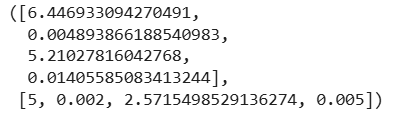

In [73]:
concrete = ConcreteMander(fc_prime=5, D=48, cover=2, dh=0.75, sh=6.0, fyh=68, esm=0.1)
concrete.confined_props(), concrete.unconfined_props()

([6.446933094270491,
  0.004893866188540983,
  5.21027816042768,
  0.01405585083413244],
 [5, 0.002, 0, 0.005])

##Single column pushover

###Haber et al

In [96]:
fc_prime = 4.334
D, H, cover = 24, 108, 1.5
#Longitudinal bar props
nBars, db = 11, 1.0
fy, fu, Es, Esh, eps_sh, eps_ult = 67, 111.0, 29000, 29000*0.043, 0.01, 0.1
#Transverse bar props
dh, sh = 0.375, 2
fyh, esm = 82, 0.1
P_axial=200
#Hyperparameters
nAng, nRad, nRad_cover = 30, 10, 6
beamIntegration = "HingeRadau"

In [97]:
col = RCCColumnPushover(
    fc_prime,
    D, H, cover,
    nBars, db,
    fy, fu, Es, Esh, eps_sh, eps_ult,
    dh, sh,
    fyh, esm,
    P_axial,
    nAng, nRad, nRad_cover, beamIntegration,
    concrete_model = "Concrete01"
)

col.run_gravity_load()
yield_step = col.run_pushover(max_disp=30, dU=0.05)
pushover_df = col.get_results()

Total axial load = 204.24087864874096
unconfined props: [-4.334, -0.002, 0, -0.005]
confined props: [-6.809438347445055, -0.007711671313901836, -5.978952048548908, -0.022055896274374896]
Reinforcing steel props: 67 111.0 29000 1247.0 0.01 0.1
G, J, GJ= 1563.536656110115 32572.032632418974 50927566.98480191
I-modifier= 0.49477563612668946
Plastic hinge length: 20.10 in
✅ Gravity load applied.
🚀 Starting pushover...
⚠️ Yield reached at disp = 0.700 in at step = 14
Step 20: Disp = 1.000 in, Vb = 49.30 kip
Step 40: Disp = 2.000 in, Vb = 49.49 kip
Step 60: Disp = 3.000 in, Vb = 51.27 kip
Step 80: Disp = 4.000 in, Vb = 52.50 kip
Step 100: Disp = 5.000 in, Vb = 53.10 kip
Step 120: Disp = 6.000 in, Vb = 53.45 kip
Step 140: Disp = 7.000 in, Vb = 53.49 kip
Step 160: Disp = 8.000 in, Vb = 53.29 kip
Step 180: Disp = 9.000 in, Vb = 52.88 kip
⚠️ Concrete fiber reached εu = -0.0221 (< -0.022055896274374896) at disp = 9.400 in
✅ Pushover complete.
📊 Results saved to pushover_results.csv


In [98]:
bilinear_df, Dy, Vy, Dp, Vp, Du, Vu = caltrans_bilinear(pushover_df, yield_index=yield_step)

print(f"Yield point: Δy = {Dy:.3f} in, Vy = {Vy:.2f} kip")
print(f"Plastic hinge point: Δp = {Dp:.3f} in, Vp = {Vp:.2f} kip")
print(f"Ultimate: Δu = {Du:.3f} in, Vu = {Vu:.2f} kip")

Yield point: Δy = 0.700 in, Vy = 42.25 kip
Plastic hinge point: Δp = 0.865 in, Vp = 52.22 kip
Ultimate: Δu = 9.400 in, Vu = 53.50 kip


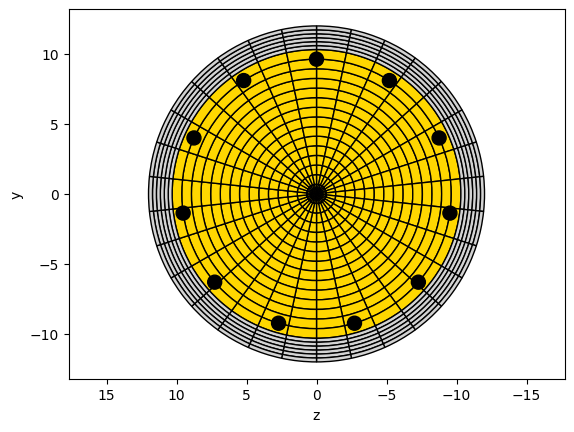

In [63]:
col.plot_fib_section()

In [99]:
haber = pd.read_excel('parametric_Haber.xlsx', sheet_name="measured")
haber.head()

,Disp. (in),"Base shear (Measured: Haber, 2013)"
0,0.000000,0.0000
1,0.135965,11.4135
2,0.244750,17.5570
3,0.507009,28.6180
4,0.770944,37.8165


In [100]:
fig = go.Figure()

# OpenSees model trace
fig.add_trace(
    go.Scatter(
        x=pushover_df['Disp (in)'],
        y=pushover_df['Base Shear (kip)'],
        mode='lines+markers',
        name='OpenSees Model',
        line=dict(width=2),
        marker=dict(size=6)
    )
)

# Bilinear idealization
fig.add_trace(go.Scatter(
    x=bilinear_df['Disp (in)'],
    y=bilinear_df['Base Shear (kip)'],
    mode='lines+markers',
    name='Caltrans Idealized',
    line=dict(dash='dash', width=3, color='red')
))

# Haber (2013) trace
fig.add_trace(
    go.Scatter(
        x=haber['Disp. (in)'],
        y=haber['Base shear (Measured: Haber, 2013)'],
        mode='lines+markers',
        name='Haber (2013)',
        line=dict(dash='dot', width=2, color='green'),
        marker=dict(size=6)
    )
)

# Layout
fig.update_layout(
    title=dict(
        text='Pushover Curve: CIP Column',
        x=0.5,              # center align
        y=0.95,             # move it closer to the plot
        xanchor='center',
        yanchor='top',
        font=dict(size=18)  # optional: adjust title font size
    ),
    width=750,
    height=500,
    xaxis_title='Displacement (in)',
    yaxis_title='Base Shear (kip)',
    legend=dict(
        x=0.65, y=0.25,
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(t=60, b=50, l=60, r=20)  # reduce top margin
)

fig.show()


###Cheok et al

In [49]:
cheok = pd.read_excel('parametric_Cheok.xlsx', sheet_name="measured", header=None)
cheok.head()

,0,1
0,0.000000,0.000000
1,1.487324,127.605634
2,2.298592,180.000000
3,3.042254,219.718310
4,3.447887,235.774648


In [45]:
fc_prime = 5.2
D, H, cover = 60, 360, 2
#Longitudinal bar props
nBars, db = 25, 1.693
fy, fu, Es, Esh, eps_sh, eps_ult = 68.875, 78.3, 29000, 29000*0.043, 0.0098, 0.088
#Transverse bar props
dh, sh = 0.626, 3.5
fyh, esm = 71.485, 0.12
P_axial=1000
#Hyperparameters
nAng, nRad, nRad_cover = 40,20,6
beamIntegration = "HingeRadau"

In [46]:
col = RCCColumnPushover(
    fc_prime,
    D, H, cover,
    nBars, db,
    fy, fu, Es, Esh, eps_sh, eps_ult,
    dh, sh,
    fyh, esm,
    P_axial,
    nAng, nRad, nRad_cover, beamIntegration, concrete_model = "Concrete04"
)

col.run_gravity_load()
yield_step = col.run_pushover(max_disp=30, dU=0.05)
pushover_df = col.get_results()

Total axial load = 1088.3516385154364
unconfined props: [-5.2, -0.002, 0, -0.005]
confined props: [-6.626687183170517, -0.0047436291984048395, -5.024562261074759, -0.01551204110678184]
Reinforcing steel props: 68.875 78.3 29000 1247.0 0.0098 0.088
G, J, GJ= 1712.636855845395 1272345.024703866 2179064982.659361
Ieff= 304657.83811975573
Plastic hinge length: 46.29 in
✅ Gravity load applied.
🚀 Starting pushover...
Step 20: Disp = 1.000 in, Vb = 86.51 kip
Step 40: Disp = 2.000 in, Vb = 157.61 kip
⚠️ Yield reached at disp = 2.850 in at step = 57
Step 60: Disp = 3.000 in, Vb = 223.06 kip
Step 80: Disp = 4.000 in, Vb = 259.82 kip
Step 100: Disp = 5.000 in, Vb = 273.95 kip
Step 120: Disp = 6.000 in, Vb = 278.09 kip
Step 140: Disp = 7.000 in, Vb = 279.87 kip
Step 160: Disp = 8.000 in, Vb = 280.07 kip
Step 180: Disp = 9.000 in, Vb = 277.69 kip
Step 200: Disp = 10.000 in, Vb = 277.14 kip
Step 220: Disp = 11.000 in, Vb = 276.21 kip
Step 240: Disp = 12.000 in, Vb = 275.47 kip
Step 260: Disp = 13.00

In [47]:
bilinear_df, Dy, Vy, Dp, Vp, Du, Vu = caltrans_bilinear(pushover_df, yield_index=yield_step)

print(f"Yield point: Δy = {Dy:.3f} in, Vy = {Vy:.2f} kip")
print(f"Plastic hinge point: Δp = {Dp:.3f} in, Vp = {Vp:.2f} kip")
print(f"Ultimate: Δu = {Du:.3f} in, Vu = {Vu:.2f} kip")

Yield point: Δy = 2.850 in, Vy = 214.44 kip
Plastic hinge point: Δp = 3.570 in, Vp = 268.66 kip
Ultimate: Δu = 22.350 in, Vu = 280.95 kip


In [50]:
fig = go.Figure()

# OpenSees model trace
fig.add_trace(
    go.Scatter(
        x=pushover_df['Disp (in)'],
        y=pushover_df['Base Shear (kip)'],
        mode='lines+markers',
        name='OpenSees Model',
        line=dict(width=2),
        marker=dict(size=6)
    )
)

# Bilinear idealization
fig.add_trace(go.Scatter(
    x=bilinear_df['Disp (in)'],
    y=bilinear_df['Base Shear (kip)'],
    mode='lines+markers',
    name='Caltrans Idealized',
    line=dict(dash='dash', width=3, color='red')
))

# Experimental
fig.add_trace(
    go.Scatter(
        x=cheok[0],
        y=cheok[1],
        mode='lines+markers',
        name='Cheok et al',
        line=dict(dash='dot', width=2, color='green'),
        marker=dict(size=6)
    )
)

# Layout
fig.update_layout(
    title=dict(
        text='Pushover Curve',
        x=0.5,              # center align
        y=0.95,             # move it closer to the plot
        xanchor='center',
        yanchor='top',
        font=dict(size=18)  # optional: adjust title font size
    ),
    width=750,
    height=500,
    xaxis_title='Displacement (in)',
    yaxis_title='Base Shear (kip)',
    legend=dict(
        x=0.65, y=0.25,
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(t=60, b=50, l=60, r=20)  # reduce top margin
)

fig.show()


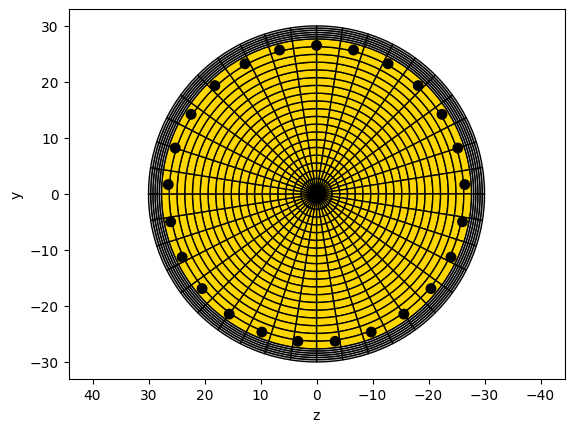

In [51]:
col.plot_fib_section()

###UCSD column

In [33]:
fc_prime = 6.1
D, H, cover = 48, 324, 2
#Longitudinal bar props
nBars, db = 18, 1.41
# fy, fu, Es, Esh, eps_sh, eps_ult = 75.2, 102.4, 28400, 800, 0.011, 0.122
fy, fu, Es, Esh, eps_sh, eps_ult = 75.2, 102.4, 29000, 1247, 0.005, 0.122
#Transverse bar props
dh, sh = 0.883889, 6   #double hoop
fyh, esm = 54.8, 0.125
P_axial=570   #axial load
#Hyperparameters
nAng, nRad, nRad_cover = 30,10,10
beamIntegration = "HingeRadau"

In [34]:
col = RCCColumnPushover(
    fc_prime,
    D, H, cover,
    nBars, db,
    fy, fu, Es, Esh, eps_sh, eps_ult,
    dh, sh,
    fyh, esm,
    P_axial,
    nAng, nRad, nRad_cover, beamIntegration, concrete_model = "Concrete01"
)

col.run_gravity_load()
yield_step = col.run_pushover(max_disp=30, dU=0.05)
pushover_df = col.get_results()

Total axial load = 620.8905437848914
unconfined props: [-6.1, -0.002, 0, -0.005]
confined props: [-7.737097653145092, -0.004683766644500152, -5.538208582939792, -0.015759667113427793]
Reinforcing steel props: 75.2 102.4 29000 1247 0.005 0.122
G, J, GJ= 1854.9342980278304 521152.5221187036 966703687.7816908
Ieff= 103351.94442720752
Plastic hinge length: 41.82 in
✅ Gravity load applied.
🚀 Starting pushover...
Step 20: Disp = 1.000 in, Vb = 42.77 kip
Step 40: Disp = 2.000 in, Vb = 76.11 kip
⚠️ Yield reached at disp = 2.950 in at step = 59
Step 60: Disp = 3.000 in, Vb = 106.99 kip
Step 80: Disp = 4.000 in, Vb = 124.94 kip
Step 100: Disp = 5.000 in, Vb = 131.38 kip
Step 120: Disp = 6.000 in, Vb = 134.23 kip
Step 140: Disp = 7.000 in, Vb = 135.34 kip
Step 160: Disp = 8.000 in, Vb = 134.92 kip
Step 180: Disp = 9.000 in, Vb = 134.69 kip
Step 200: Disp = 10.000 in, Vb = 134.70 kip
Step 220: Disp = 11.000 in, Vb = 134.67 kip
Step 240: Disp = 12.000 in, Vb = 134.59 kip
Step 260: Disp = 13.000 in,

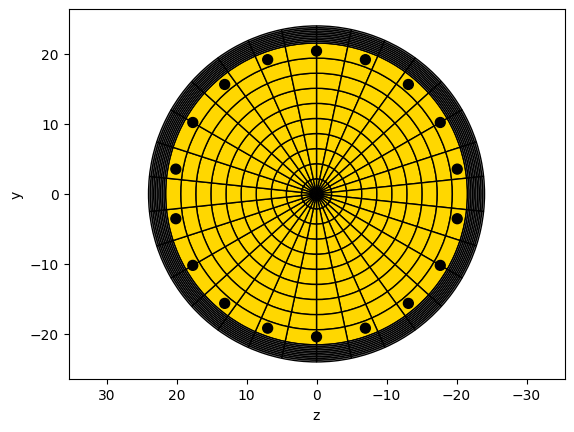

In [ ]:
col.plot_fib_section()

In [35]:
bilinear_df, Dy, Vy, Dp, Vp, Du, Vu = caltrans_bilinear(pushover_df, yield_index=yield_step)

print(f"Yield point: Δy = {Dy:.3f} in, Vy = {Vy:.2f} kip")
print(f"Plastic hinge point: Δp = {Dp:.3f} in, Vp = {Vp:.2f} kip")
print(f"Ultimate: Δu = {Du:.3f} in, Vu = {Vu:.2f} kip")

Yield point: Δy = 2.950 in, Vy = 105.64 kip
Plastic hinge point: Δp = 3.639 in, Vp = 130.30 kip
Ultimate: Δu = 25.650 in, Vu = 135.35 kip


In [36]:
fig = go.Figure()

# OpenSees model trace
fig.add_trace(
    go.Scatter(
        x=pushover_df['Disp (in)'],
        y=pushover_df['Base Shear (kip)'],
        mode='lines+markers',
        name='OpenSees Model',
        line=dict(width=2),
        marker=dict(size=6)
    )
)

# Bilinear idealization
fig.add_trace(go.Scatter(
    x=bilinear_df['Disp (in)'],
    y=bilinear_df['Base Shear (kip)'],
    mode='lines+markers',
    name='Opensees Idealized',
    line=dict(dash='dash', width=3, color='red')
))

In [37]:
sap = pd.read_excel('parametric_UCSD.xlsx', sheet_name="sap", header=None)
sap.head()

,0,1
0,0.000000,0.000
1,3.000000,114.680
2,4.001637,152.969
3,7.001637,152.969
4,10.001637,152.969


In [38]:
measured = pd.read_excel('parametric_UCSD.xlsx', sheet_name="measured", header=None)
measured.head()

,0,1
0,0.000000,0.0000
1,3.103272,119.3070
2,3.970620,152.6616
3,4.237596,162.9246
4,4.504572,162.9246


In [39]:
fig = go.Figure()

# OpenSees model trace
fig.add_trace(
    go.Scatter(
        x=pushover_df['Disp (in)'],
        y=pushover_df['Base Shear (kip)'],
        mode='lines+markers',
        name='OpenSees Model',
        line=dict(width=2),
        marker=dict(size=6)
    )
)

# Bilinear idealization
fig.add_trace(go.Scatter(
    x=bilinear_df['Disp (in)'],
    y=bilinear_df['Base Shear (kip)'],
    mode='lines+markers',
    name='Opensees Idealized',
    line=dict(dash='dash', width=3, color='red')
))

#Experimental
fig.add_trace(
    go.Scatter(
        x=measured[0],
        y=measured[1],
        mode='lines+markers',
        name='Experimental idealized',
        line=dict(dash='dot', width=2, color='green'),
        marker=dict(size=6)
    )
)

fig.add_trace(
    go.Scatter(
        x=sap[0],
        y=sap[1],
        mode='lines+markers',
        name='SAP idealized',
        line=dict(dash='dot', width=2, color='brown'),
        marker=dict(size=6)
    )
)

# Layout
fig.update_layout(
    title=dict(
        text='Pushover Curve',
        x=0.5,              # center align
        y=0.95,             # move it closer to the plot
        xanchor='center',
        yanchor='top',
        font=dict(size=18)  # optional: adjust title font size
    ),
    width=750,
    height=500,
    xaxis_title='Displacement (in)',
    yaxis_title='Base Shear (kip)',
    legend=dict(
        x=0.65, y=0.25,
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(t=60, b=50, l=60, r=20)  # reduce top margin
)

fig.show()


##Pushover in batch

In [102]:
# Read the CSV file with all columns
columns_df = pd.read_excel("parametric_Haber.xlsx", sheet_name="batch")

# Initialize list to collect results
summary_data = []

for i, row in columns_df.iterrows():
    print(f"\n=== Running pushover for column {i+1}/{len(columns_df)} ===")

    # Create model object
    col = RCCColumnPushover(
        fc_prime=row['fc_prime'],
        D=row['D'], H=row['H'], cover=row['cover'],
        nBars=int(row['nBars']), db=row['db'],
        fy=row['fy'], fu=row['fu'], Es=row['Es'],
        Esh=row['Esh'], eps_sh=row['eps_sh'], eps_ult=row['eps_ult'],
        dh=row['dh'], sh=row['sh'],
        fyh=row['fyh'], esm=row['esm'],
        P_axial=row['P'],
        nAng = int(row['nAng']), nRad = int(row['nRad']), nRad_cover = int(row['nRad_cover']), beamIntegration = row['beamIntegration'],
        concrete_model = row['concrete_model']
    )

    # Run analyses
    col.run_gravity_load()

    yield_step = col.run_pushover(max_disp=30, dU=0.1)
    print("yield_step", yield_step)
    pushover_df = col.get_results()

    # Caltrans bilinear idealization
    bilinear_df, Dy, Vy, Dp, Vp, Du, Vu = caltrans_bilinear(pushover_df, yield_index=yield_step)

    da = 2 * col.get_outermost_core_mesh_area()

    # Store results in summary table
    summary_data.append({
        'Dy': Dy, 'Vy': Vy, 'Dp': Dp, 'Vp': Vp, 'Du': Du, 'Vu': Vu, 'da %': da
    })

# Convert all summaries into a dataframe
summary_df = pd.DataFrame(summary_data)

# Append summary_df to columns_df
merged_df = pd.concat([columns_df, summary_df], axis=1)

# Save to CSV
merged_df.to_csv('results.csv', index=False)
print("✅ Results saved to results.csv")

# Display the merged DataFrame
display(merged_df)


=== Running pushover for column 1/16 ===
Total axial load = 204.24087864874096
unconfined props: [-4.334, -0.002, 0, -0.005]
confined props: [-6.809438347445055, -0.007711671313901836, -5.978952048548908, -0.022055896274374896]
Reinforcing steel props: 67 111 29000 1247 0.01 0.1
G, J, GJ= 1563.536656110115 32572.032632418974 50927566.98480191
I-modifier= 0.49477563612668946
Plastic hinge length: 20.10 in
✅ Gravity load applied.
🚀 Starting pushover...
⚠️ Yield reached at disp = 0.700 in at step = 7
Step 20: Disp = 2.000 in, Vb = 49.38 kip
Step 40: Disp = 4.000 in, Vb = 52.28 kip
Step 60: Disp = 6.000 in, Vb = 52.57 kip
Step 80: Disp = 8.000 in, Vb = 52.40 kip
Step 100: Disp = 10.000 in, Vb = 51.45 kip
⚠️ Concrete fiber reached εu = -0.0222 (< -0.022055896274374896) at disp = 10.300 in
✅ Pushover complete.
yield_step 7
📊 Results saved to pushover_results.csv

=== Running pushover for column 2/16 ===
Total axial load = 204.24087864874096
unconfined props: [-4.334, -0.002, 0, -0.005]
conf

,fc_prime,D,H,cover,nBars,db,fy,fu,Es,Esh,...,nRad_cover,beamIntegration,concrete_model,Dy,Vy,Dp,Vp,Du,Vu,da %
0,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,41.9660,0.861705,51.660447,10.3,52.6060,3.800000
1,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2118,0.866387,52.245369,9.7,53.6356,1.900000
2,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2524,0.865139,52.220265,9.4,53.4997,1.266667
3,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2617,0.865440,52.249956,9.2,53.5696,0.950000
4,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.0807,0.866326,52.079409,9.1,53.3990,1.718519
5,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2204,0.865787,52.219804,8.9,53.5334,1.031111
6,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2595,0.866075,52.285569,9.0,53.6569,0.736508
7,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2762,0.865725,52.285076,9.1,53.6139,0.572840
8,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2193,0.866230,52.245161,9.4,53.6504,1.288889
9,4.334,24,108,1.5,11,1,67,111,29000,1247,...,6,HingeRadau,Concrete01,0.7,42.2597,0.865047,52.223748,9.2,53.5161,0.859259
